## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

## Helper Functions

In [2]:
def local_safe_divide(numerator, denominator):
    """Safely divide two numbers, returning 0 when the denominator is 0."""
    return numerator / denominator if denominator != 0 else 0

def local_sttc_ta(tA, delt, tmax):
    '''
    Helper function for spike time tiling coefficients: calculate the
    total amount of time within a range delt of spikes within the
    given sorted list of spike times tA.
    '''
    if len(tA) == 0:
        return 0

    base = min(delt, tA[0]) + min(delt, tmax - tA[-1])
    return base + np.minimum(np.diff(tA), 2 * delt).sum()

def local_sttc_na(tA, tB, delt):
    '''
    Helper function for spike time tiling coefficients: given two
    sorted lists of spike times, calculate the number of spikes in
    spike train A within delt of any spike in spike train B.
    '''
    if len(tB) == 0:
        return 0
    tA, tB = np.asarray(tA), np.asarray(tB)

    # Find the closest spike in B after spikes in A.
    iB = np.searchsorted(tB, tA, side='right')
    iB = np.clip(iB, 1, len(tB) - 1)

    dt_left = np.abs(tB[iB - 1] - tA)
    dt_right = np.abs(tA - tB[np.clip(iB, 0, len(tB) - 1)])

    # Return how many of those spikes are actually within delt.
    return np.sum(np.minimum(dt_left, dt_right) <= delt)

def local_spike_time_tiling(tA, tB, TA, TB, delt):
    """
    Internal helper method for the second half of STTC calculation.
    """
    PA = local_safe_divide(local_sttc_na(tA, tB, delt), len(tA))
    PB = local_safe_divide(local_sttc_na(tB, tA, delt), len(tB))

    aa = local_safe_divide((PA - TB), (1 - PA * TB))
    bb = local_safe_divide((PB - TA), (1 - PB * TA))
    return (aa + bb) / 2

def local_spike_time_tiling_coefficient(tA, tB, delt=20, length=None):
    """
    Calculate the spike time tiling coefficient between two spike trains.
    """
    if length is None:
        length = max(tA[-1], tB[-1]) if tA and tB else 0

    if len(tA) == 0 or len(tB) == 0:
        return 0.0

    TA = local_safe_divide(local_sttc_ta(tA, delt, length), length)
    TB = local_safe_divide(local_sttc_ta(tB, delt, length), length)
    return local_spike_time_tiling(tA, tB, TA, TB, delt)

class LocalSpikeData:
    def __init__(self, train, length, neuron_data):
        self.train = train
        self.length = length
        self.N = len(train)
        self.neuron_data = neuron_data

    def local_spike_time_tilings(self, delt=20):
        """
        Compute the full spike time tiling coefficient matrix.
        """
        T = self.length
        ts = [local_safe_divide(local_sttc_ta(ts, delt, T), T) for ts in self.train]

        ret = np.diag(np.ones(self.N))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                ret[i, j] = ret[j, i] = local_spike_time_tiling(
                    self.train[i], self.train[j], ts[i], ts[j], delt
                )
        return ret
    
def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

def position_to_grid(pos):
    # Modify this function based on your grid conversion logic
    return pos[0], pos[1]  # Example conversion

def transform_neuron_data(sd):
    original_data = sd.neuron_data
    transformed_neuron_data = {'positions': {}}

    for top_level_key, clusters in original_data.items():
        for cluster_id, cluster_info in clusters.items():
            grid_pos = position_to_grid(cluster_info['position'])
            transformed_neuron_data['positions'][cluster_id] = {'position': grid_pos}

    return SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)

## FCM Code

In [3]:
def latencies_between_two_neurons(train_a, train_b, window_ms=100):
    '''
    Compute latencies between the spike trains of two neurons.
    
    :param train_a: Spike train of the first neuron (numpy array).
    :param train_b: Spike train of the second neuron (numpy array).
    :param window_ms: Window in milliseconds to consider for latency calculation.
    :return: List of lists, where each sublist contains latencies from each spike in train_a
             to spikes in train_b within the specified window.
    '''
    latencies = []
    
    # Check if either of the trains is empty
    if len(train_a) == 0 or len(train_b) == 0:
        return latencies
    
    for spike_a in train_a:
        # Calculate differences between spike_a and all spikes in train_b
        diffs = train_b - spike_a
        # Filter the differences to find those within the specified window
        relevant_latencies = diffs[np.abs(diffs) <= window_ms]
        
        if len(relevant_latencies) > 0:
            latencies.append(relevant_latencies.tolist())
            
    return latencies

def analyze_spike_time_tilings(sd, delta_t, min_spikes, sttc_thresh, mean_thresh, pval_thresh, fwhm_thresh, local=False):
    dT = delta_t
    MIN_SPIKES = min_spikes
    N = sd.N
    STTC_THRESH = sttc_thresh
    MEAN_THRESH = mean_thresh
    PVAL_THRESH = pval_thresh
    FWHM_THRESH = fwhm_thresh

    tile_coefficients_whole = np.zeros((N, N))
    mean_latencies = np.nan * np.zeros((N, N))

    # Choose method based on the 'local' parameter
    if local:
        sttc_values = sd.local_spike_time_tilings(delt=dT)
    else:
        sttc_values = sd.spike_time_tilings(delt=dT)

    for ref_channel in range(N):
        for comp_channel in range(N):
            if ref_channel == comp_channel:
                continue
            ref_train = sd.train[ref_channel]
            comp_train = sd.train[comp_channel]
            
            # Ensure both channels have a minimum number of spikes
            if len(ref_train) > MIN_SPIKES and len(comp_train) > MIN_SPIKES:
                sttc_value = sttc_values[ref_channel, comp_channel]

                if sttc_value > STTC_THRESH:
                    latencies = latencies_between_two_neurons(ref_train, comp_train, window_ms=dT)

                    # Remove latencies larger than dT
                    latencies = [lat for sublist in latencies for lat in sublist if np.abs(lat) <= dT]

                    if np.abs(np.mean(latencies)) > 0:
                        pdf = np.sort(latencies)

                        # Compute the dip test
                        dip, p_val = diptest.diptest(pdf)

                        if p_val > PVAL_THRESH:
                            pd_mean = np.mean(pdf)
                            pd_std = np.std(pdf)
                            pd_fwhm = 2 * np.sqrt(2 * np.log(2)) * pd_std

                            if pd_fwhm < FWHM_THRESH:
                                mean_latencies[comp_channel, ref_channel] = pd_mean
                                # Adjust storage based on mean latency direction
                                if np.abs(mean_latencies[comp_channel, ref_channel]) > MEAN_THRESH:
                                    tile_coefficients_whole[comp_channel, ref_channel] = sttc_value

    return tile_coefficients_whole, mean_latencies

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

## Network Computation

In [4]:
def compute_connectivity_data(sd, tile_coefficients_whole, latency_threshold=.1, compute_sttc=False):
    """
    Computes the necessary data for plotting the functional connectivity map.
    
    Args:
        sd (SpikeData object): The standard data format for braingeneers.
        latency_threshold (float): Threshold for fraction of in/out signals for "sender" or "receiver" labeling.
        sttc_threshold (float): Threshold for strength of spike time tiling correlation.
        compute_sttc (bool): If True, computes spike time tiling correlations.
        
    Returns:
        A dictionary containing precomputed data for plotting.
    """
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold)
    
    data = {
        'sender_receiver_neurons': sender_receiver_neurons,
        'neuron_positions': sd.neuron_data['positions'],
    }
    
    if compute_sttc:
        print("calculating STTC...")
        sttc = tile_coefficients_whole  # Assuming this is a function or data you have
        data['sttc'] = sttc
    
    return data

## Plotter

In [128]:
def plot_functional_connectivity_map(precomputed_data, title, size, legends_loc, sttc_threshold=.1, show_sttc=True):
    """
    Plots the functional connectivity map using precomputed data.
    
    Args:
        precomputed_data (dict): Data computed by compute_connectivity_data.
        title (str): Title for the plot.
        sttc_threshold (float): Threshold for spike time tiling correlation plotting.
        show_sttc (bool): If True, plots spike time tiling connections.
    """
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in precomputed_data['neuron_positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(size[0], size[1]))
    plt.scatter(neuron_x, neuron_y, c=precomputed_data['sender_receiver_neurons'])
    
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])
    plt.gca().add_artist(node_type_legend)
    plt.title(title)
    plt.xlabel('X position')
    plt.ylabel('Y position')

    if show_sttc and 'sttc' in precomputed_data:
        sttc = precomputed_data['sttc']
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue  # Skip duplicates and self-connections
                if sttc[i,j] < sttc_threshold: continue
                ix, iy = precomputed_data['neuron_positions'][i]['position']
                jx, jy = precomputed_data['neuron_positions'][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[1])
        plt.gca().add_artist(correlation_legend)
    
    plt.gca().invert_yaxis()  # Invert y axis to match the image
    plt.axis('equal')  # Make x and y axis equal
    # Limit x and y axis
    plt.xlim(0, 1800)
    plt.ylim(600, 1500)
    #save with high res
    plt.savefig('fcm-' + title + '.png', dpi=300)
    # plt.savefig('fcm-' + title + '.png')
    plt.show()

In [6]:
def plot_functional_connectivity_map_rotated(precomputed_data, title, size, legends_loc, sttc_threshold=.1, show_sttc=True):
    """
    Plots the functional connectivity map using precomputed data, rotated 90 degrees clockwise.
    
    Args:
        precomputed_data (dict): Data computed by compute_connectivity_data.
        title (str): Title for the plot.
        sttc_threshold (float): Threshold for spike time tiling correlation plotting.
        show_sttc (bool): If True, plots spike time tiling connections.
    """
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in precomputed_data['neuron_positions'].values():
        # Swap x and y positions for rotation
        neuron_x.append(neuron['position'][1])  # Originally y
        neuron_y.append(neuron['position'][0])  # Originally x
    plt.figure(figsize=(size[1], size[0]))  # Swap size dimensions
    plt.scatter(neuron_x, neuron_y, c=precomputed_data['sender_receiver_neurons'])
    
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
        plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])
    plt.gca().add_artist(node_type_legend)
    plt.title(title)
    # Swap labels for x and y axis
    plt.xlabel('Y position')
    plt.ylabel('X position')

    if show_sttc and 'sttc' in precomputed_data:
        sttc = precomputed_data['sttc']
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue  # Skip duplicates and self-connections
                if sttc[i,j] < sttc_threshold: continue
                # Swap positions for rotation
                ix, iy = precomputed_data['neuron_positions'][i]['position'][1], precomputed_data['neuron_positions'][i]['position'][0]
                jx, jy = precomputed_data['neuron_positions'][j]['position'][1], precomputed_data['neuron_positions'][j]['position'][0]
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[1])
        plt.gca().add_artist(correlation_legend)
    
    plt.gca().invert_xaxis()  # Invert x axis to achieve 90-degree clockwise rotation effect
    plt.axis('equal')  # Make x and y axis equal
    # Save with high resolution
    plt.savefig('fcm-rotated-' + title + '.png', dpi=300)
    plt.show()

In [7]:
from human_hip import spike_data

hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip')
hc_112823 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base_acqm.zip')
hc_112823_2 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base2_acqm.zip')
hc_120523_chip21769 = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_base.zip")

hc_328 = transform_neuron_data(hc_328)
hc_52 = transform_neuron_data(hc_52)
hc_111 = transform_neuron_data(hc_111)
hc_112823 = transform_neuron_data(hc_112823)
hc_112823_2 = transform_neuron_data(hc_112823_2)
hc_120523_chip21769 = transform_neuron_data(hc_120523_chip21769)

/tmp/ipykernel_18054/3302845650.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
/tmp/ipykernel_18054/3302845650.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
/tmp/ipykernel_18054/3302845650.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/der

## HC-328

In [8]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_328, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_328_data = compute_connectivity_data(hc_328, tile_coeffs, latency_threshold=0.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


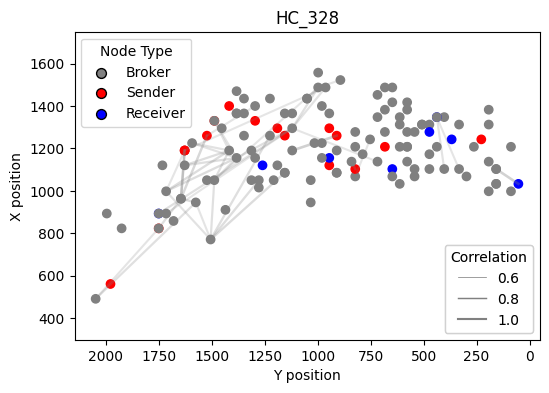

In [9]:
plot_functional_connectivity_map_rotated(hc_328_data, title='HC_328', size=(4, 6), legends_loc=['upper left', 'lower right'], sttc_threshold=0.1, show_sttc=True)

## HC-52

In [10]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_52, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_52_data = compute_connectivity_data(hc_52, tile_coeffs, latency_threshold=.2, compute_sttc=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/diptest/diptest.py:168: UserWarning: Dip test is not valid for n <= 3
  warnings.warn("Dip test is not valid for n <= 3", stacklevel=1)


calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


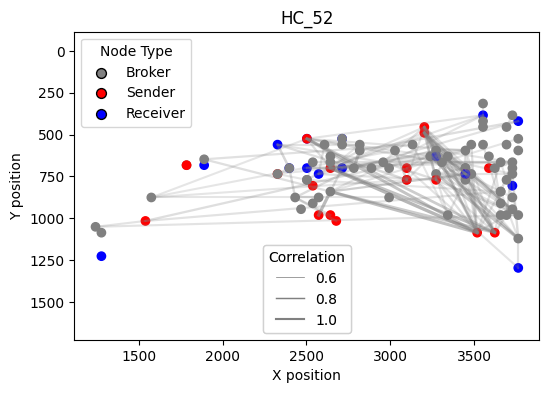

In [11]:
plot_functional_connectivity_map(hc_52_data, title='HC_52', size=(6,4), legends_loc=['upper left', 'lower center'], sttc_threshold=.1, show_sttc=True)

## HC-111

In [12]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_111, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_111_data = compute_connectivity_data(hc_111, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


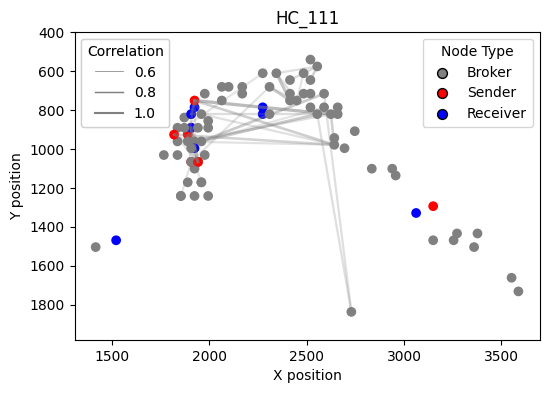

In [13]:
plot_functional_connectivity_map(hc_111_data, title='HC_111', size=(6,4), legends_loc=['upper right', 'upper left'], sttc_threshold=.1, show_sttc=True)

## HC-112823

In [14]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_112823, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_112823_data = compute_connectivity_data(hc_112823, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


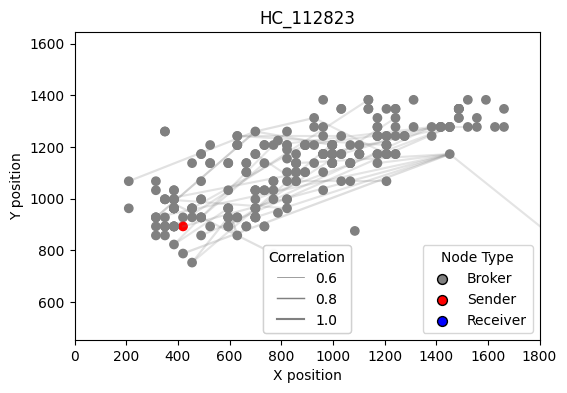

In [129]:
plot_functional_connectivity_map(hc_112823_data, title='HC_112823', size=(6, 4), legends_loc=['lower right', 'lower center'], sttc_threshold=.1, show_sttc=True)

## HC-112823-2

In [16]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_112823_2, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_112823_2_data = compute_connectivity_data(hc_112823_2, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


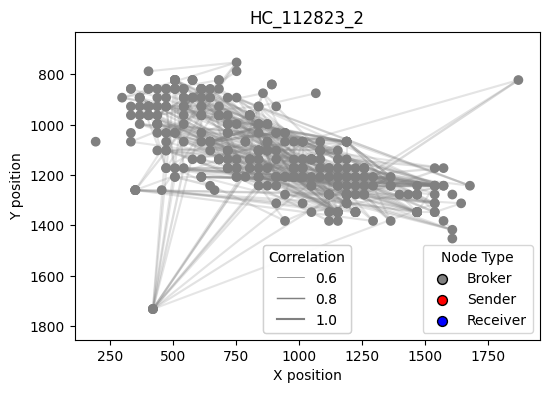

In [17]:
plot_functional_connectivity_map(hc_112823_2_data, title='HC_112823_2', size=(6,4), legends_loc=['lower right', 'lower center'], sttc_threshold=.1, show_sttc=True)

## HC-120523-chip21769

In [18]:
tile_coeffs, mean_latencies = analyze_spike_time_tilings(hc_120523_chip21769, delta_t=20, min_spikes=5, sttc_thresh=0.05, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=30)
hc_120523_chip21769_data = compute_connectivity_data(hc_120523_chip21769, tile_coeffs, latency_threshold=.2, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18054/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


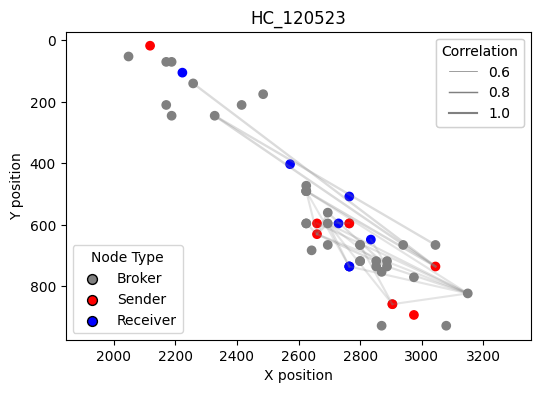

In [19]:
plot_functional_connectivity_map(hc_120523_chip21769_data, title='HC_120523', size=(6,4), legends_loc=['lower left', 'upper right'], sttc_threshold=.1, show_sttc=True)

In [130]:
# Pickle each of the datasets into a single dictionary

plotting_datasets = {
    'hc_328': hc_328_data,
    'hc_52': hc_52_data,
    'hc_111': hc_111_data,
    'hc_112823': hc_112823_data,
    'hc_112823_2': hc_112823_2_data,
    'hc_120523_chip21769': hc_120523_chip21769_data
}

with open('plotting_datasets.pkl', 'wb') as file:
    pickle.dump(plotting_datasets, file)

In [30]:
def combined_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 3x2 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # This figsize might need tweaking
    
    for idx, (data, title, sttc_threshold, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx // 2, idx % 2]  # Determine the correct subplot location
        plt.sca(ax)  # Set the current axes to ax
        
        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'])

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    # correlation_legend = ax.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[0])
    # node_type_legend = ax.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])

    # Optional: Add legends outside the subplots or in an empty subplot if you have one
    plt.figlegend(handles=node_type_legend_elements, loc='upper right', title='Node Type')
    plt.figlegend(handles=correlation_legend_elements, loc='upper left', title='Correlation')

    plt.savefig('combined_functional_connectivity_maps_adjusted.png', dpi=300)
    plt.show()

In [171]:
def combined_ca1_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 2x1 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(2, 1, figsize=(6,6))  # Adjusted for two subplots one on top of the other

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='Low STTC'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='Medium STTC'),
        plt.Line2D([0], [0], color='grey',linewidth=1.5, label='High STTC')
    ]
    
    for idx, (data, title, sttc_threshold, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx]  # Adjusted for a 2x1 subplot grid
        plt.sca(ax)  # Set the current axes to ax
    
        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'])

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            # ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

    # Add two legends within one of the two subplots
    plt.figlegend(handles=node_type_legend_elements, loc='center right', title='Node Type')
    plt.figlegend(handles=correlation_legend_elements, loc='center left', title='Correlation')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)
    
    # plt.figlegend(handles=node_type_legend_elements, loc='lower right', bbox_to_anchor=(1, 0.5), title='Node Type')
    # plt.figlegend(handles=correlation_legend_elements, loc='center left', bbox_to_anchor=(0, 0.5), title='Correlation')
    

    plt.savefig('combined_ca1_functional_connectivity_maps_adjusted.png', dpi=300)
    plt.show()


In [165]:
def combined_dg_functional_connectivity_plots(data_info):
    """
    Creates a combined figure of functional connectivity maps, with adjustments based on user feedback.
    Legends are added only once, and subplot dimensions follow a 3:2 aspect ratio.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, size, legends_loc, sttc_threshold, show_sttc, is_rotated)
    """
    # Create the overall figure with a layout of 3x2 subplots
    # Adjust the figsize to control the size of the entire figure and try to maintain subplot aspect ratio
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # This figsize might need tweaking
    
    for idx, (data, title, sttc_threshold, x_spatial_window, y_spatial_window, show_sttc, is_rotated) in enumerate(data_info):
        ax = axs[idx // 2, idx % 2]  # Determine the correct subplot location
        plt.sca(ax)  # Set the current axes to ax

        # Preparing neuron positions
        neuron_x = []
        neuron_y = []
        for neuron_id, neuron in data['neuron_positions'].items():
            if is_rotated:
                neuron_x.append(neuron['position'][1])  # Originally y
                neuron_y.append(neuron['position'][0])  # Originally x
            else:
                neuron_x.append(neuron['position'][0])
                neuron_y.append(neuron['position'][1])
        
        # Plotting neuron positions
        ax.scatter(neuron_x, neuron_y, c=data['sender_receiver_neurons'])

        # Plotting STTC connections if requested
        if show_sttc and 'sttc' in data:
            sttc = data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue  # Skip duplicates and self-connections
                    if sttc[i, j] < sttc_threshold: continue
                    if is_rotated:
                        ix, iy = data['neuron_positions'][i]['position'][1], data['neuron_positions'][i]['position'][0]
                        jx, jy = data['neuron_positions'][j]['position'][1], data['neuron_positions'][j]['position'][0]
                    else:
                        ix, iy = data['neuron_positions'][i]['position']
                        jx, jy = data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)

        # Setting title and axis labels
        ax.set_title(title)
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            ax.invert_xaxis()  # For rotation effect
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            ax.invert_yaxis()  # To match the image as needed

        ax.axis('equal')

        ax.set_xlim(x_spatial_window)
        ax.set_ylim(y_spatial_window)

    # Adjust subplot parameters to give specified padding
    plt.tight_layout(pad=0.5)

    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='black', label='Broker', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', label='Sender', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markeredgecolor='black', label='Receiver', markersize=10)
    ]

    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
        plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
        plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
    ]

    # correlation_legend = ax.legend(handles=correlation_legend_elements, title='Correlation', loc=legends_loc[0])
    # node_type_legend = ax.legend(handles=node_type_legend_elements, title='Node Type', loc=legends_loc[0])

    # Optional: Add legends outside the subplots or in an empty subplot if you have one
    plt.figlegend(handles=node_type_legend_elements, loc='upper right', title='Node Type')
    plt.figlegend(handles=correlation_legend_elements, loc='upper left', title='Correlation')

    plt.savefig('combined_functional_connectivity_maps_adjusted.png', dpi=300)
    plt.show()

In [150]:
# Open plotting datasets
with open('plotting_datasets.pkl', 'rb') as file:
    plotting_datasets = pickle.load(file)

In [133]:
hc_328_data = plotting_datasets['hc_328']
hc_52_data = plotting_datasets['hc_52']
hc_111_data = plotting_datasets['hc_111']
hc_112823_data = plotting_datasets['hc_112823']
hc_112823_2_data = plotting_datasets['hc_112823_2']
hc_120523_chip21769_data = plotting_datasets['hc_120523_chip21769']

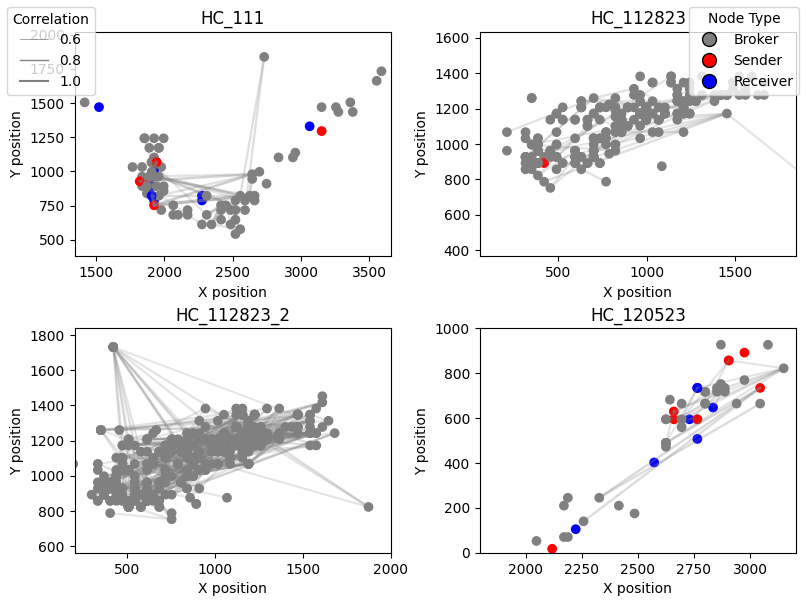

In [170]:
dg_data_info = [
    (hc_111_data, 'HC_111', 0.1, (1400, 3600), (400, 2000), True, False),
    (hc_112823_data, 'HC_112823', 0.1,(100, 1800), (800, 1200), True, False),
    (hc_112823_2_data, 'HC_112823_2', 0.1, (200, 2000), (600, 1800), True, False),
    (hc_120523_chip21769_data, 'HC_120523', 0.1, (1800, 3200), (0, 1000), True, False),
]

combined_dg_functional_connectivity_plots(dg_data_info)


# data_info = [
#     (hc_112823_data, 'HC_112823', 0.1, True, False),
#     (hc_112823_2_data, 'HC_112823_2', 0.1, True, False),
#     (hc_111_data, 'HC_111', 0.1, True, False),
#     (hc_120523_chip21769_data, 'HC_120523', 0.1, True, False),
# ]

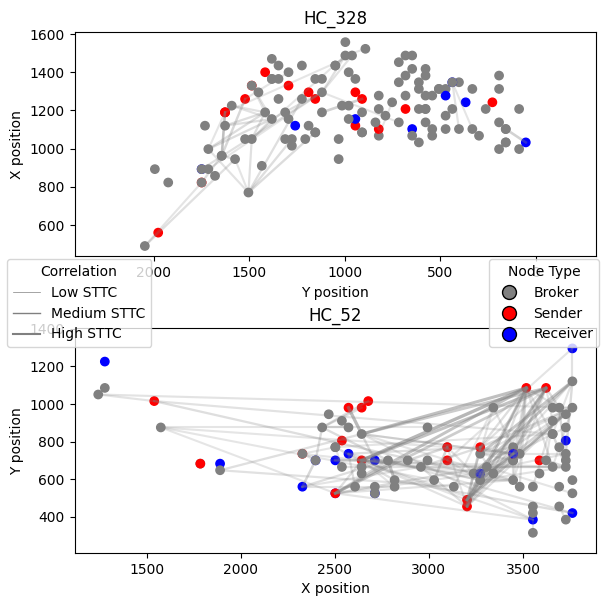

In [172]:
ca1_data_info = [
    (hc_328_data, 'HC_328', 0.1, True, True),
    (hc_52_data, 'HC_52', 0.1, True, False)
]

combined_ca1_functional_connectivity_plots(ca1_data_info)

ValueError: not enough values to unpack (expected 7, got 5)

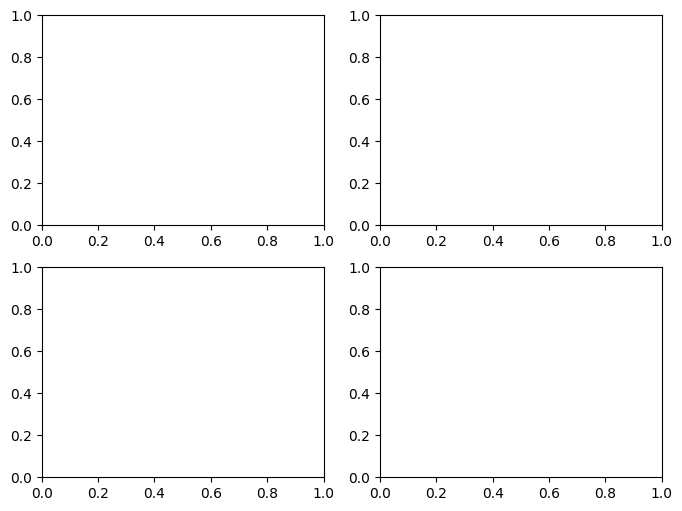

In [153]:
data_info = [
    (hc_112823_data, 'HC_112823', 0.1, True, False),
    (hc_112823_2_data, 'HC_112823_2', 0.1, True, False),
    (hc_111_data, 'HC_111', 0.1, True, False),
    (hc_120523_chip21769_data, 'HC_120523', 0.1, True, False),
]

combined_dg_functional_connectivity_plots(data_info)

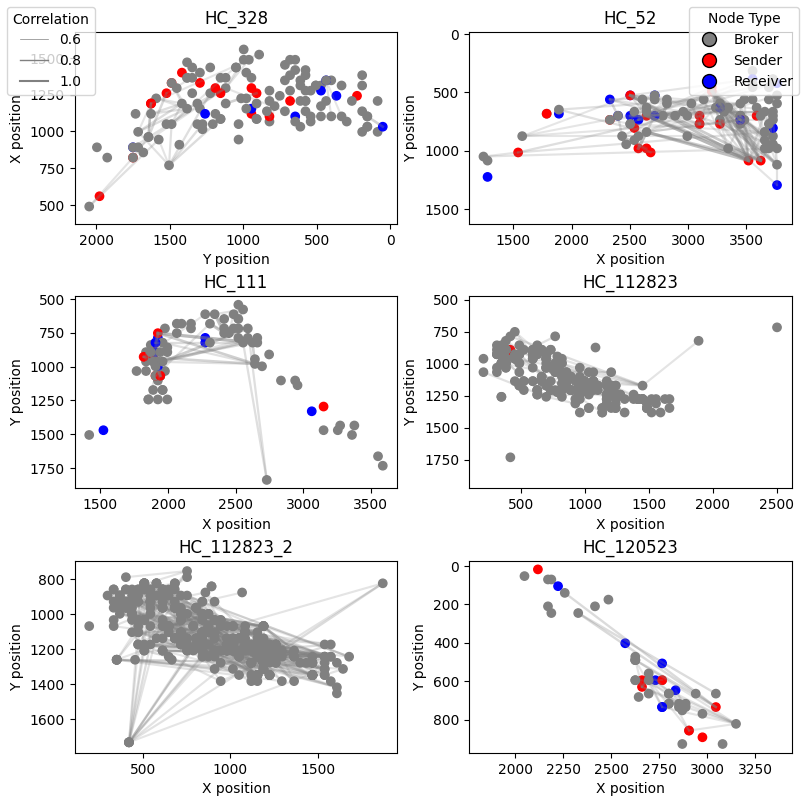

In [154]:
# data_info = [
#     # Assuming hc_328_data is prepared similarly to your described structure
#     (hc_328_data, 'HC_328', (4, 6), ['upper left', 'lower right'], 0.1, True, True),
#     (hc_52_data, 'HC_52', (4, 6), ['upper left', 'lower right'], 0.1, True, False),
#     (hc_111_data, 'HC_111', (4, 6), ['upper left', 'lower right'], 0.1, True, False),
#     # Assuming hc_52_data is prepared similarly to your described structure
#     (hc_112823, 'HC_112823', (6, 4), ['upper left', 'lower center'], 0.1, True, False),
#     (hc_112823_2, 'HC_112823_2', (6, 4), ['upper left', 'lower center'], 0.1, True, False),
#     (hc_120523_chip21769_data, 'HC_120523', (6, 4), ['upper left', 'lower center'], 0.1, True, False),
# ]

data_info = [
    (hc_328_data, 'HC_328', 0.1, True, True),
    (hc_52_data, 'HC_52', 0.1, True, False),
    (hc_111_data, 'HC_111', 0.1, True, False),
    (hc_112823_data, 'HC_112823', 0.1, True, False),
    (hc_112823_2_data, 'HC_112823_2', 0.1, True, False),
    (hc_120523_chip21769_data, 'HC_120523', 0.1, True, False),
]

combined_functional_connectivity_plots(data_info)

## Data 'Hc112723_hckcr1_21841_120323_base_acqm.zip'

In [7]:
from human_hip import spike_data
sd = spike_data.read_autocurated_data('data/Hc112723_hckcr1_21841_120323_base_acqm.zip')

In [9]:
sd_cleaned = transform_neuron_data(sd)

/tmp/ipykernel_1806/1600989955.py:103: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  original_data = sd.neuron_data


In [14]:
random_tile_coefficients_whole, random_mean_latencies = analyze_spike_time_tilings(sd_cleaned, delta_t=200, min_spikes=5, sttc_thresh=0.1, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=160, local=False)

In [15]:
sd_data = compute_connectivity_data(sd_cleaned, random_tile_coefficients_whole, latency_threshold=0.1, compute_sttc=True)

calculating all latencies...


calculating STTC...


/tmp/ipykernel_1806/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


In [1]:
plot_functional_connectivity_map(sd_data, 'Functional Connectivity Map', sttc_threshold=0.1, show_sttc=True)

NameError: name 'plot_functional_connectivity_map' is not defined

making plot


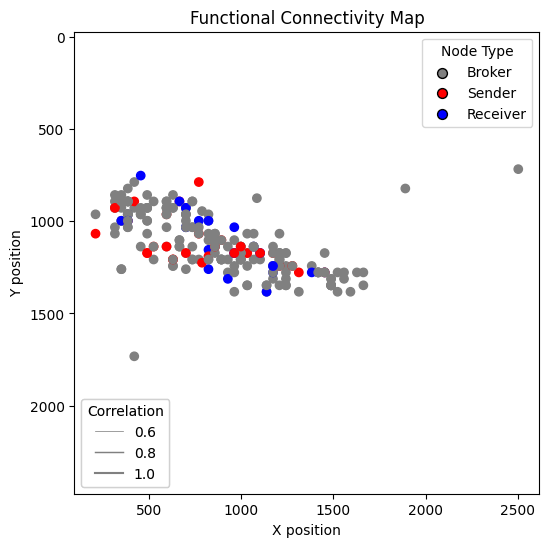

In [13]:
plot_functional_connectivity_map(sd_data, title='Functional Connectivity Map', sttc_threshold=0.1, show_sttc=True)

In [22]:
sd_data = compute_connectivity_data(sd_cleaned, random_tile_coefficients_whole, latency_threshold=0.1, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18180/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


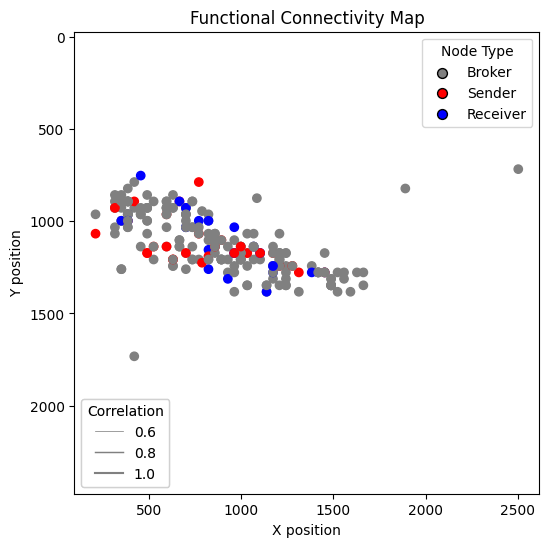

In [23]:
plot_functional_connectivity_map(sd_data, 'Functional Connectivity Map', sttc_threshold=0.1, show_sttc=True)

In [24]:
sd2 = spike_data.read_autocurated_data('data/Hc112723_hckcr1_21841_120323_base2_acqm.zip')

In [25]:
original_data = sd2.neuron_data

# New structure initialization
transformed_neuron_data2 = {'positions': {}}

# Helper function to convert position to grid coordinates (modify this as needed)
def position_to_grid(pos):
    # This is a placeholder function. You need to define how to convert your original positions
    # to the target grid positions. This might involve normalization, rounding, etc.
    return pos[0], pos[1]  # Example conversion

# Process original data to populate new structure
for top_level_key, clusters in original_data.items():
    for cluster_id, cluster_info in clusters.items():
        grid_pos = position_to_grid(cluster_info['position'])
        # Assuming cluster_id is unique across all top-level keys
        transformed_neuron_data2['positions'][cluster_id] = {'position': grid_pos}

/tmp/ipykernel_18180/3144468347.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  original_data = sd2.neuron_data


In [26]:
# sd_cleaned = SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)
sd_cleaned2 = SpikeData(train=sd2.train, length=sd2.length, neuron_data=transformed_neuron_data2)

In [27]:
tile_coefficients_whole2, mean_latencies2 = analyze_spike_time_tilings(sd_cleaned2, delta_t=100, min_spikes=5, sttc_thresh=0.01, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=80, local=False)

/srv/conda/envs/notebook/lib/python3.10/site-packages/diptest/diptest.py:168: UserWarning: Dip test is not valid for n <= 3
  warnings.warn("Dip test is not valid for n <= 3", stacklevel=1)


In [28]:
sd_data2 = compute_connectivity_data(sd_cleaned2, tile_coefficients_whole2, latency_threshold=0.1, compute_sttc=True)

calculating all latencies...
calculating STTC...


/tmp/ipykernel_18180/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


making plot


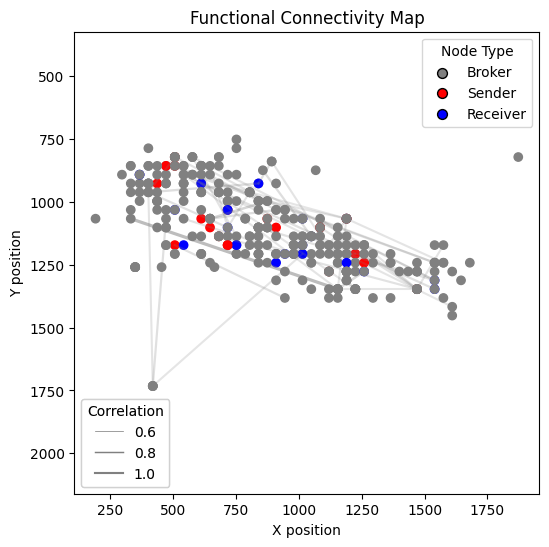

In [29]:
plot_functional_connectivity_map(sd_data2, 'Functional Connectivity Map', sttc_threshold=0.1, show_sttc=True)

In [18]:
random_tile_coefficients_whole, random_mean_latencies = analyze_spike_time_tilings(random_spike_data, delta_t=100, min_spikes=5, sttc_thresh=0.1, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=80, local=False)
plane_wave_tile_coefficients_whole, plane_wave_mean_latencies = analyze_spike_time_tilings(plane_wave_spike_data, delta_t=100, min_spikes=5, sttc_thresh=0.1, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=80, local=False)
ring_wave_tile_coefficients_whole, ring_wave_mean_latencies = analyze_spike_time_tilings(ring_wave_spike_data, delta_t=100, min_spikes=5, sttc_thresh=0.1, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=80, local=False)
rotating_circle_wave_tile_coefficients_whole, rotating_circle_wave_mean_latencies = analyze_spike_time_tilings(local_rotating_circle_wave_spike_data, delta_t=100, min_spikes=5, sttc_thresh=0.1, mean_thresh=2, pval_thresh=0.1, fwhm_thresh=80, local=True)

In [19]:
random_data = compute_connectivity_data(random_spike_data, random_tile_coefficients_whole, compute_sttc=True)
plane_wave_data = compute_connectivity_data(plane_wave_spike_data, plane_wave_tile_coefficients_whole, compute_sttc=True)
ring_wave_data = compute_connectivity_data(ring_wave_spike_data, ring_wave_tile_coefficients_whole, compute_sttc=True)
rotating_circle_wave_data = compute_connectivity_data(rotating_circle_wave_spike_data, rotating_circle_wave_tile_coefficients_whole, compute_sttc=True)

calculating all latencies...


/tmp/ipykernel_11167/319543331.py:21: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  'neuron_positions': sd.neuron_data['positions'],


calculating STTC...
calculating all latencies...
calculating STTC...
calculating all latencies...
calculating STTC...
calculating all latencies...
calculating STTC...


# PLOTTER

In [27]:
def plot_functional_connectivity_maps(precomputed_datas, titles, sttc_thresholds=[0.1, 0.2, 0.55, 0.4], show_sttc=True):
    """
    Plots four functional connectivity maps using precomputed data for each, arranged in a 2x2 grid,
    adjusted for narrower page widths.
    
    Args:
        precomputed_datas (list of dict): List of data computed by compute_connectivity_data for each dataset.
        titles (list of str): Titles for each subplot.
        sttc_threshold (float): Threshold for spike time tiling correlation plotting.
        show_sttc (bool): If True, plots spike time tiling connections for each map.
    """
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Adjusted figure size for narrower pages
    axs = axs.flatten()  # Flatten the 2x2 grid to easily iterate over

    for ax, precomputed_data, title, sttc_threshold in zip(axs, precomputed_datas, titles, sttc_thresholds):
        neuron_x = []
        neuron_y = []
        for neuron in precomputed_data['neuron_positions'].values():
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])
        ax.scatter(neuron_x, neuron_y, c=precomputed_data['sender_receiver_neurons'], s=20)  # Adjusted marker size
        
        ax.set_title(title, fontsize=10)  # Adjusted font size
        ax.set_xlabel('X position', fontsize=8)  # Adjusted font size
        ax.set_ylabel('Y position', fontsize=8)  # Adjusted font size
    
        if show_sttc and 'sttc' in precomputed_data:
            sttc = precomputed_data['sttc']
            for i in range(sttc.shape[0]):
                for j in range(sttc.shape[1]):
                    if i <= j: continue
                    if sttc[i,j] < sttc_threshold: continue
                    ix, iy = precomputed_data['neuron_positions'][i]['position']
                    jx, jy = precomputed_data['neuron_positions'][j]['position']
                    linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                    opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)
                    ax.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        
        ax.invert_yaxis()
        ax.axis('equal')
        ax.tick_params(axis='both', which='major', labelsize=8)  # Adjusted tick label size
    
    # Node Type Legend
    node_type_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=5, label='Broker'),  # Adjusted marker size
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Sender'),  # Adjusted marker size
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Receiver')  # Adjusted marker size
    ]
    fig.legend(handles=node_type_legend_elements, loc='center right', title="Node Type", fontsize=8)  # Adjusted font size
    
    # STTC Correlation Legend
    correlation_legend_elements = [
        plt.Line2D([0], [0], color='grey', linewidth=1/5, label='Low'),
        plt.Line2D([0], [0], color='grey', linewidth=3/5, label='Medium'),
        plt.Line2D([0], [0], color='grey', linewidth=5/5, label='High')
    ]
    fig.legend(handles=correlation_legend_elements, loc='center left', title="Correlation", fontsize=8)  # Adjusted font size

    plt.tight_layout()
    plt.savefig('functional_connectivity_maps.png', dpi=300)  # Save the figure as a high-resolution PNG
    plt.show()

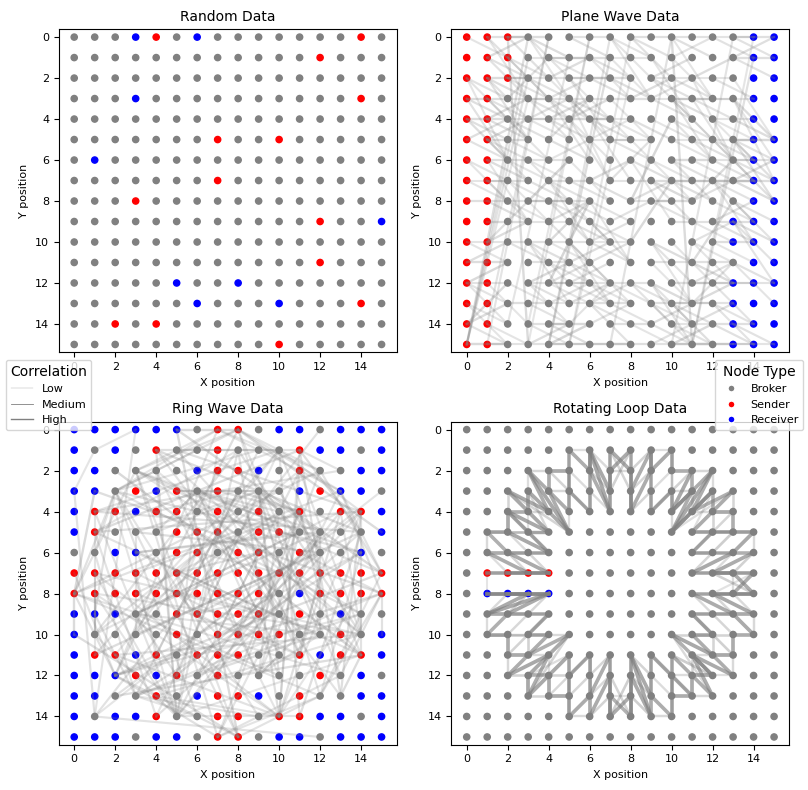

In [25]:
plot_functional_connectivity_maps([random_data, plane_wave_data, ring_wave_data, rotating_circle_wave_data], ['Random Data', 'Plane Wave Data', 'Ring Wave Data', 'Rotating Loop Data'], show_sttc=True)